In [16]:
#Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.utils import resample

In [17]:
#Read the dataset
df = pd.read_csv('Station-data-for-ML.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime'] = df['datetime'].astype(object)
df.shape

(49323, 7)

In [18]:
df.head()

,datetime,station_name,rain_fall,temperature,humidity,wind_speed,wind_direction
0,2016-01-15 00:00:00,QuangNgai,0.6,23.0,93.0,4.0,0.0
1,2016-01-15 01:00:00,QuangNgai,0.0,20.7,94.0,4.0,4.0
2,2016-01-15 02:00:00,QuangNgai,0.0,19.8,94.0,4.0,18.0
3,2016-01-15 03:00:00,QuangNgai,0.0,22.2,93.0,4.0,31.0
4,2016-01-15 04:00:00,QuangNgai,1.0,23.2,94.0,4.0,44.0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49323 entries, 0 to 49322
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   datetime        49323 non-null  object 
 1   station_name    49323 non-null  object 
 2   rain_fall       48067 non-null  float64
 3   temperature     49323 non-null  float64
 4   humidity        49323 non-null  float64
 5   wind_speed      49321 non-null  float64
 6   wind_direction  49323 non-null  float64
dtypes: float64(5), object(2)
memory usage: 2.6+ MB


In [20]:
#Check Null Values
df.isnull().sum()

datetime             0
station_name         0
rain_fall         1256
temperature          0
humidity             0
wind_speed           2
wind_direction       0
dtype: int64

In [21]:
#Check Duplicate Values
df.duplicated().sum()

0

In [22]:
#Check unique values
df.nunique()

datetime          16441
station_name          3
rain_fall           525
temperature         244
humidity             56
wind_speed           18
wind_direction      361
dtype: int64

In [23]:
# Định nghĩa hàm để chuyển đổi độ sang hướng
def degrees_to_direction(degrees):
    if degrees >= 0 and degrees < 22.5 or degrees >= 337.5 and degrees <= 360:
        return 'N'
    elif degrees >= 22.5 and degrees < 45:
        return 'NNE'
    elif degrees >= 45 and degrees < 67.5:
        return 'NE'
    elif degrees >= 67.5 and degrees < 90:
        return 'ENE'
    elif degrees >= 90 and degrees < 112.5:
        return 'E'
    elif degrees >= 112.5 and degrees < 135:
        return 'ESE'
    elif degrees >= 135 and degrees < 157.5:
        return 'SE'
    elif degrees >= 157.5 and degrees < 180:
        return 'SSE'
    elif degrees >= 180 and degrees < 202.5:
        return 'S'
    elif degrees >= 202.5 and degrees < 225:
        return 'SSW'
    elif degrees >= 225 and degrees < 247.5:
        return 'SW'
    elif degrees >= 247.5 and degrees < 270:
        return 'WSW'
    elif degrees >= 270 and degrees < 292.5:
        return 'W'
    elif degrees >= 292.5 and degrees < 315:
        return 'WNW'
    elif degrees >= 315 and degrees < 337.5:
        return 'NW'
    elif degrees >= 337.5 and degrees < 360:
        return 'NNW'

# Áp dụng hàm chuyển đổi cho cột 'wind_direction'
df['wind_direction'] = df['wind_direction'].apply(degrees_to_direction)

# Hiển thị DataFrame sau khi chuyển đổi
df.head()

,datetime,station_name,rain_fall,temperature,humidity,wind_speed,wind_direction
0,2016-01-15 00:00:00,QuangNgai,0.6,23.0,93.0,4.0,N
1,2016-01-15 01:00:00,QuangNgai,0.0,20.7,94.0,4.0,N
2,2016-01-15 02:00:00,QuangNgai,0.0,19.8,94.0,4.0,N
3,2016-01-15 03:00:00,QuangNgai,0.0,22.2,93.0,4.0,NNE
4,2016-01-15 04:00:00,QuangNgai,1.0,23.2,94.0,4.0,NNE


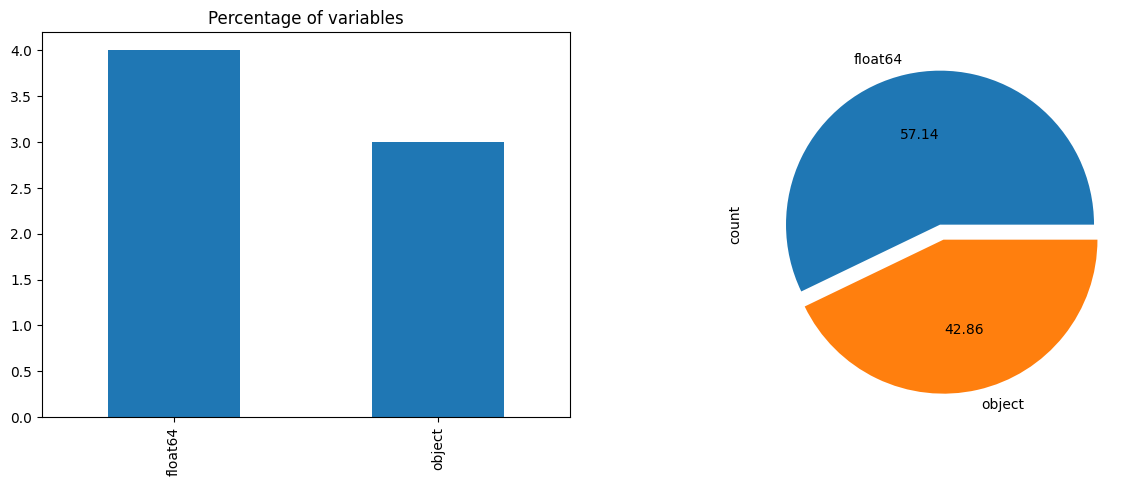

In [24]:
# Percetage of categorical and numerical columns in the dataset
cat_cols = list(df.select_dtypes(include='object').columns)
num_cols = list(df.select_dtypes(exclude='object').columns)

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax1 = plt.subplot(1,2,1)
plt.title('Percentage of variables', loc='center')
df.dtypes.value_counts().plot(kind='bar')

ax2 = plt.subplot(1,2,2)
df.dtypes.value_counts().plot(kind='pie', autopct='%0.2f', ax=ax2, explode=[0,0.1])
plt.show()

In [25]:
print('Categorical columns are :\n', cat_cols)
print()
print('Numerical columns are :\n', num_cols)

Categorical columns are :
 ['datetime', 'station_name', 'wind_direction']

Numerical columns are :
 ['rain_fall', 'temperature', 'humidity', 'wind_speed']


In [26]:
# Five point summary for numrerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rain_fall,48067.0,2.663235,9.329759,0.0,0.0,0.0,0.6,371.0
temperature,49323.0,27.130984,4.009831,15.3,24.5,26.8,29.6,40.2
humidity,49323.0,87.820652,8.893067,44.0,83.0,91.0,95.0,100.0
wind_speed,49321.0,2.482046,1.811965,0.0,1.0,2.0,3.0,18.0


In [27]:
# Five point summary for categorical variables
df.describe(include='object').T

C:\Users\ntdun\AppData\Local\Temp\ipykernel_24552\700036865.py:2: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  df.describe(include='object').T


,count,unique,top,freq
datetime,49323,16441,2016-01-15 00:00:00,3
station_name,49323,3,QuangNgai,16441
wind_direction,49323,15,N,6142


C:\Users\ntdun\AppData\Local\Temp\ipykernel_24552\1454617110.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['rain_fall'])


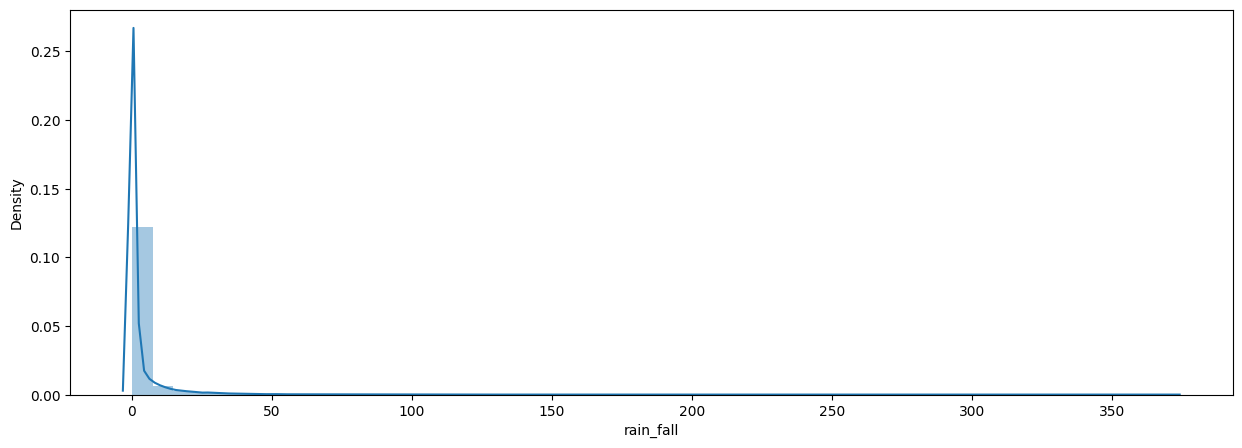

In [28]:
# Distribution of Rainfall
plt.figure(figsize=(15,5))
sns.distplot(df['rain_fall'])
plt.show()

C:\Users\ntdun\AppData\Local\Temp\ipykernel_24552\956943431.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['temperature'],  bins=25)


<Axes: title={'center': 'Temperature Distribution'}, xlabel='temperature', ylabel='Density'>

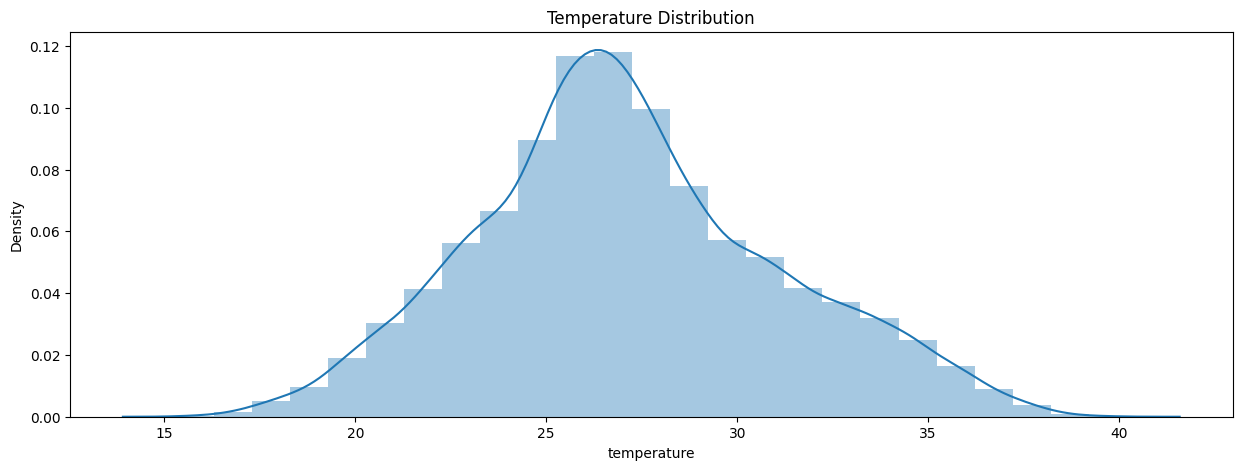

In [29]:
fig, ax = plt.subplots(figsize=(15,5))
plt.title('Temperature Distribution')
sns.distplot(df['temperature'],  bins=25)

C:\Users\ntdun\AppData\Local\Temp\ipykernel_24552\1686268286.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


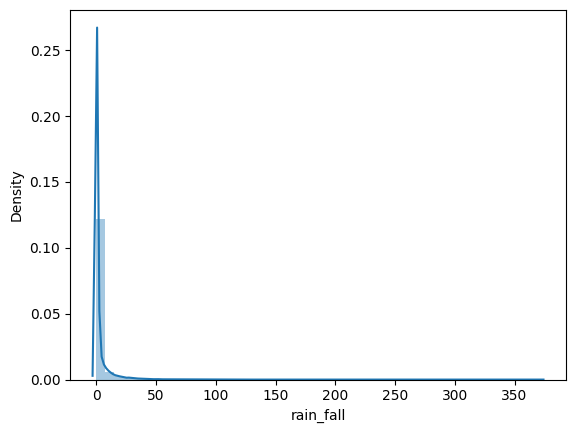

C:\Users\ntdun\AppData\Local\Temp\ipykernel_24552\1686268286.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


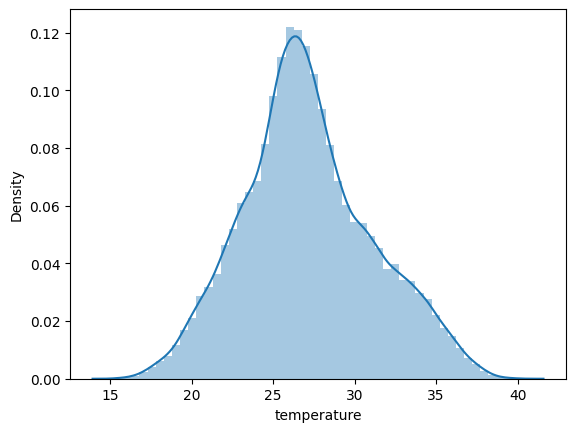

C:\Users\ntdun\AppData\Local\Temp\ipykernel_24552\1686268286.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


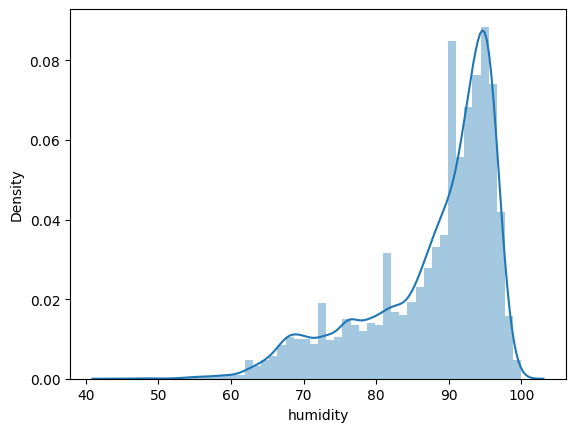

C:\Users\ntdun\AppData\Local\Temp\ipykernel_24552\1686268286.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


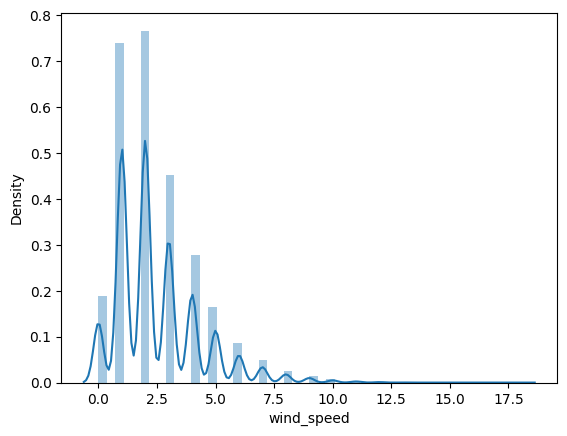

In [30]:
# Distribution plots for numerical variables
for col in num_cols:
    sns.distplot(df[col])
    plt.show()

In [31]:
# Unique locations and its name
print('Number of stations :', len(df['station_name'].unique()))
df['station_name'].unique()

Number of stations : 3


array(['QuangNgai', 'TraKhuc', 'AnChi'], dtype=object)

C:\Users\ntdun\AppData\Local\Temp\ipykernel_24552\1875130615.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['station_name'],palette=["#87CEFA","#00BFFF","#1E90FF"])


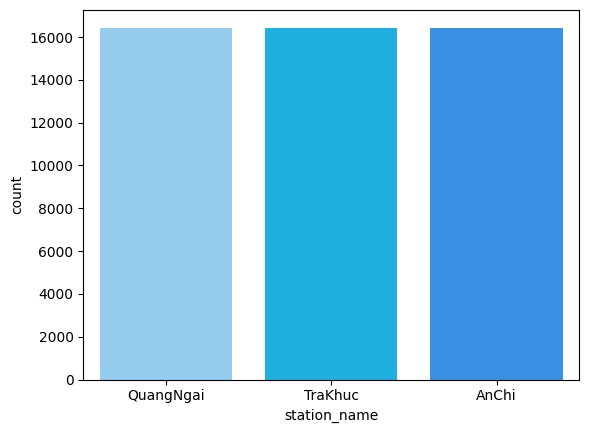

In [32]:
# Number of observations for each station
sns.countplot(x=df['station_name'],palette=["#87CEFA","#00BFFF","#1E90FF"])
plt.show()

C:\Users\ntdun\AppData\Local\Temp\ipykernel_24552\1718491149.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['wind_direction'], palette=["#9195F6","#B7C9F2","#F9F07A","#FB88B4","#94FFD8","#A3D8FF","#FC4100","#7BD3EA","#FF4B91","#0079FF","#00DFA2","#F45050","#00FF00","#00FFFF","#B0C4DE","#708090"])
C:\Users\ntdun\AppData\Local\Temp\ipykernel_24552\1718491149.py:3: UserWarning: The palette list has more values (16) than needed (15), which may not be intended.
  sns.countplot(x=df['wind_direction'], palette=["#9195F6","#B7C9F2","#F9F07A","#FB88B4","#94FFD8","#A3D8FF","#FC4100","#7BD3EA","#FF4B91","#0079FF","#00DFA2","#F45050","#00FF00","#00FFFF","#B0C4DE","#708090"])


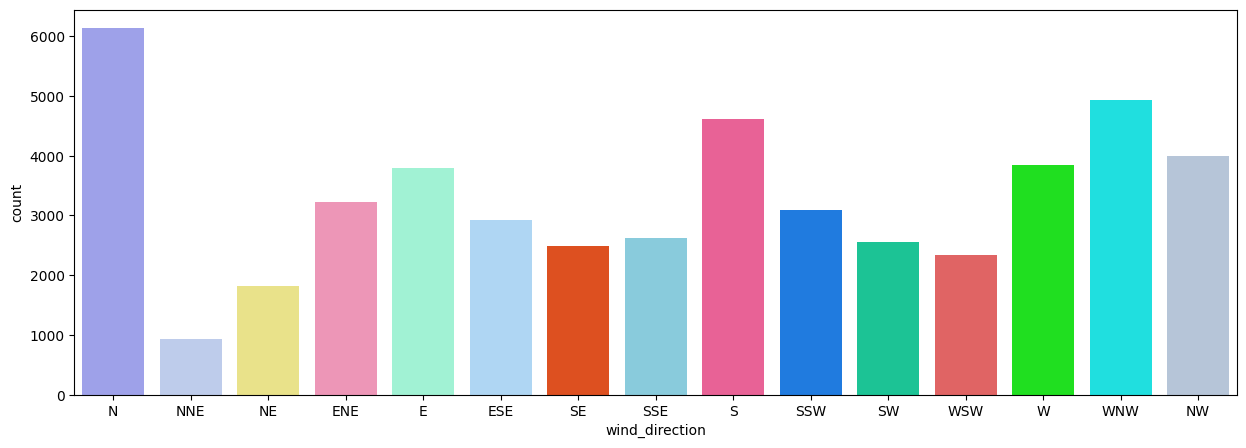

In [33]:
# Count plot for wind_direction
plt.figure(figsize=(15,5))
sns.countplot(x=df['wind_direction'], palette=["#9195F6","#B7C9F2","#F9F07A","#FB88B4","#94FFD8","#A3D8FF","#FC4100","#7BD3EA","#FF4B91","#0079FF","#00DFA2","#F45050","#00FF00","#00FFFF","#B0C4DE","#708090"])
plt.show()

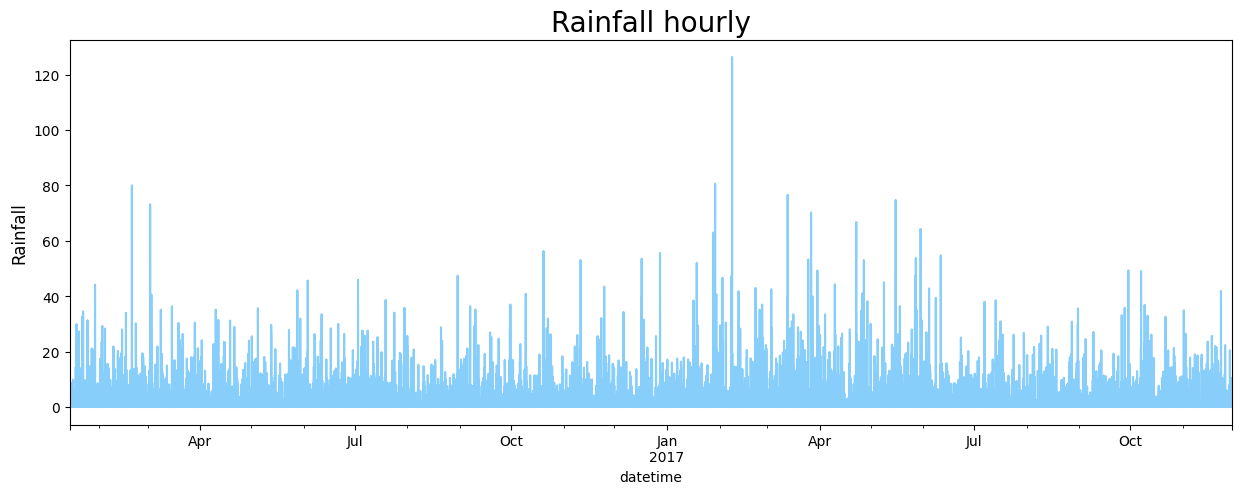

In [34]:
# Average rainfall based on month and day
plt.figure(figsize=(15,5))
df.groupby(by=['datetime'])['rain_fall'].mean().plot(color = "#87CEFA")
plt.title('Rainfall hourly', fontsize=20)
plt.ylabel('Rainfall', fontsize=12)
plt.show()

In [35]:
# Average rainfall data
df.groupby(by=['datetime'])[['rain_fall']].mean().T

datetime,2016-01-15 00:00:00,2016-01-15 01:00:00,2016-01-15 02:00:00,2016-01-15 03:00:00,2016-01-15 04:00:00,2016-01-15 05:00:00,2016-01-15 06:00:00,2016-01-15 07:00:00,2016-01-15 08:00:00,2016-01-15 09:00:00,...,2017-11-29 15:00:00,2017-11-29 16:00:00,2017-11-29 17:00:00,2017-11-29 18:00:00,2017-11-29 19:00:00,2017-11-29 20:00:00,2017-11-29 21:00:00,2017-11-29 22:00:00,2017-11-29 23:00:00,2017-11-30 00:00:00
rain_fall,1.4,0.066667,0.0,0.0,0.333333,0.066667,0.266667,0.0,0.0,0.466667,...,0.0,3.066667,4.266667,1.0,0.066667,3.6,5.333333,1.066667,10.6,1.933333


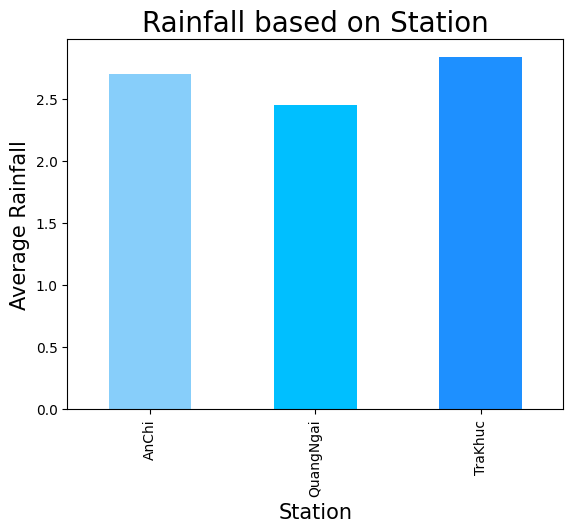

In [36]:

# Average rainfall based on location
df.groupby(by=['station_name'])['rain_fall'].mean().plot(kind='bar', color=["#87CEFA","#00BFFF","#1E90FF"])
plt.title('Rainfall based on Station', fontsize=20)
plt.ylabel('Average Rainfall', fontsize=15)
plt.xlabel('Station', fontsize=15)
plt.show()

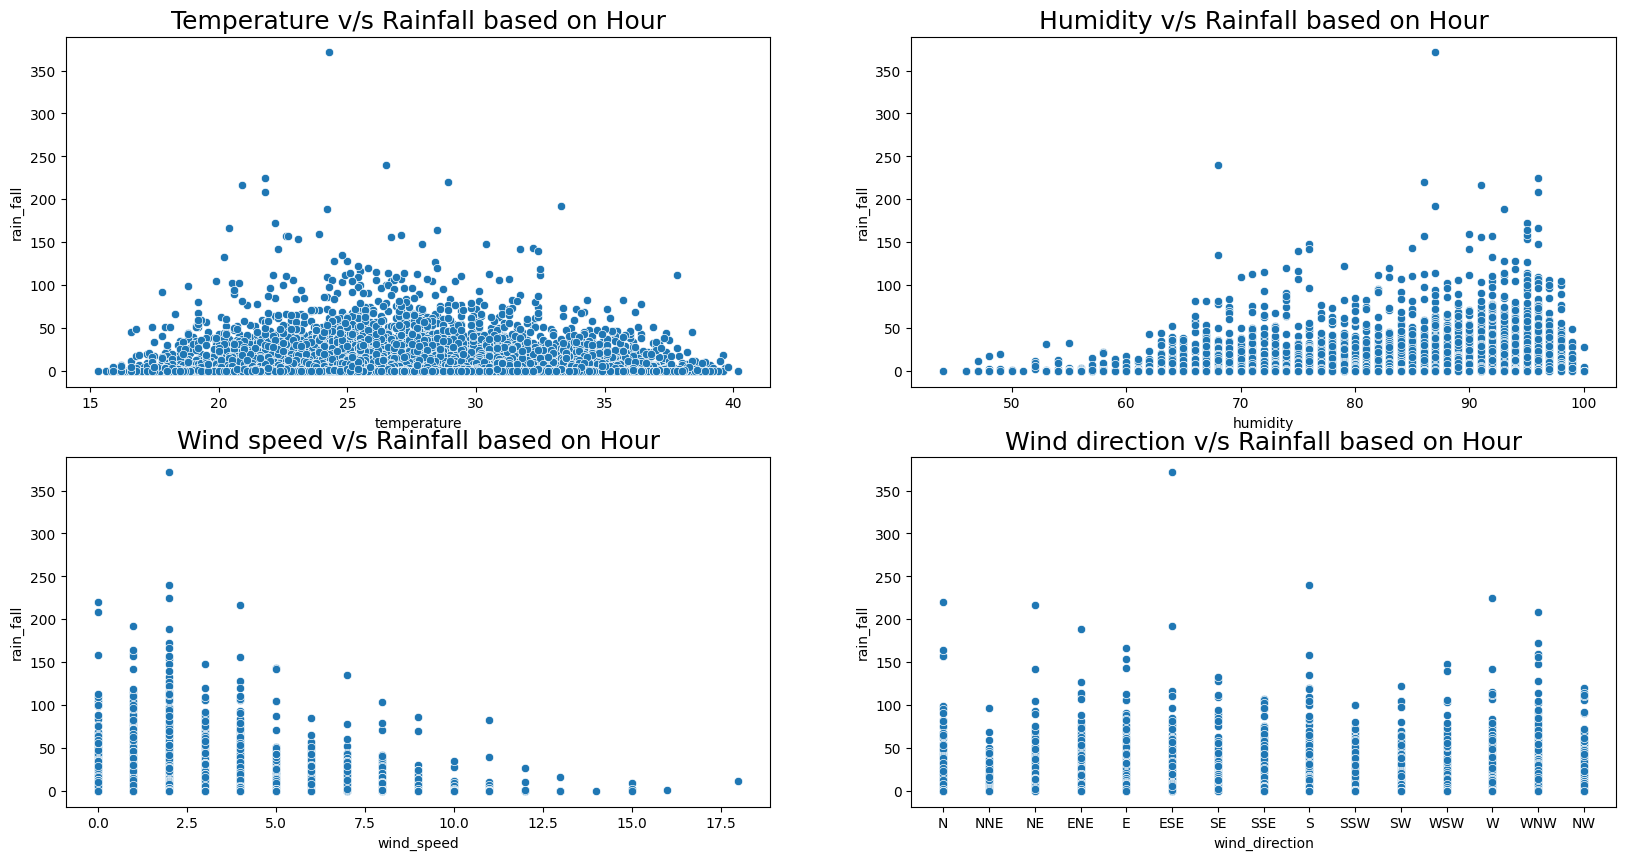

In [37]:
# Wind direction at different timespan
fig, ax = plt.subplots(2, 2, figsize=(20,10))

ax1 = plt.subplot(2, 2, 1)
plt.title('Temperature v/s Rainfall based on Hour', fontsize=18)
sns.scatterplot(data=df, x='temperature', y='rain_fall', ax=ax1)

ax2 = plt.subplot(2, 2, 2)
plt.title('Humidity v/s Rainfall based on Hour', fontsize=18)
sns.scatterplot(data=df, x='humidity', y='rain_fall', ax=ax2)

ax3 = plt.subplot(2, 2, 3)
plt.title('Wind speed v/s Rainfall based on Hour', fontsize=18)
sns.scatterplot(data=df, x='wind_speed', y='rain_fall', ax=ax3)

ax4 = plt.subplot(2, 2, 4)
plt.title('Wind direction v/s Rainfall based on Hour', fontsize=18)
sns.scatterplot(data=df, x='wind_direction', y='rain_fall', ax=ax4)
plt.show()

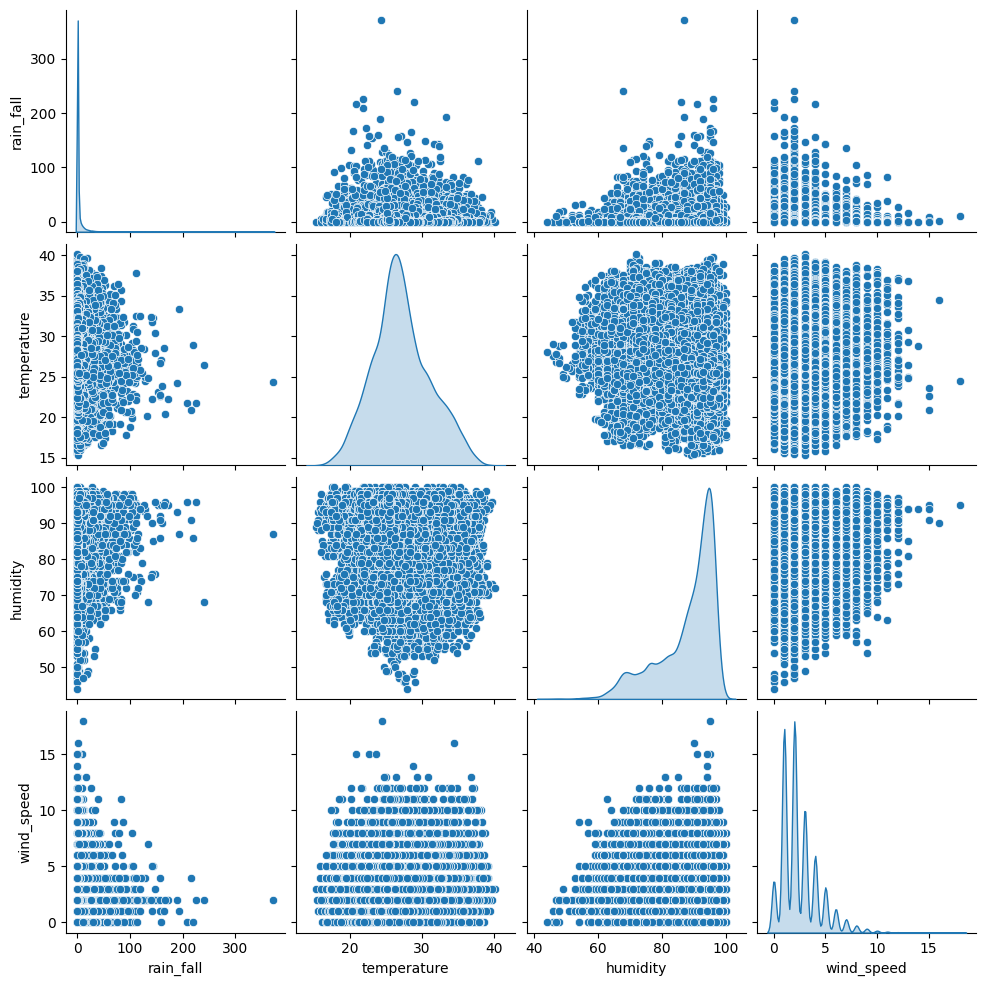

In [38]:
# Relation between all the variables
sns.pairplot((df.drop(columns=['datetime'], axis=1)), diag_kind='kde')
plt.show()

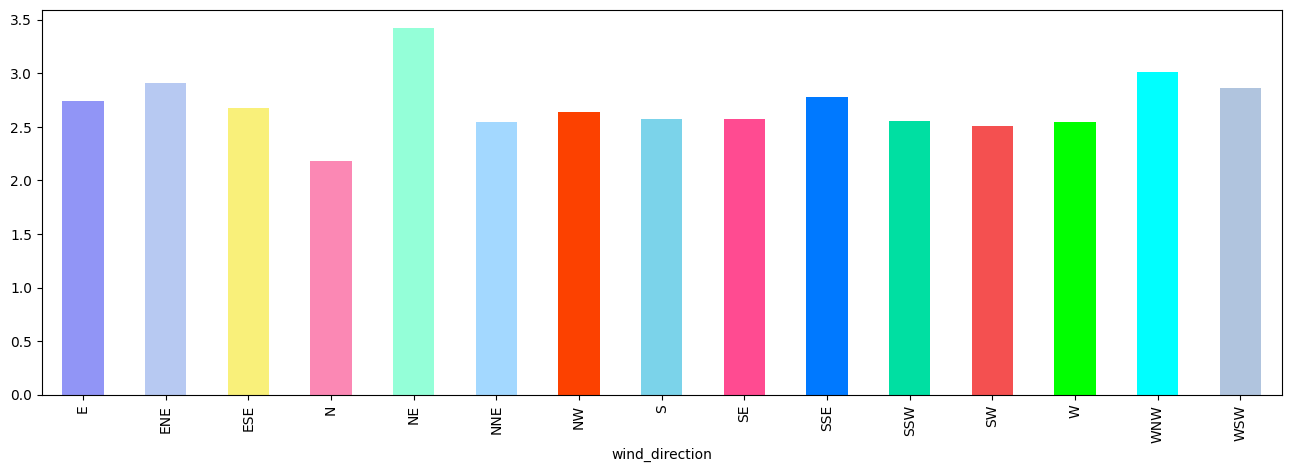

In [39]:
# Avg. rainfall based on wind direction
plt.figure(figsize=(16,5))
df.groupby(by=['wind_direction'])['rain_fall'].mean().plot(kind='bar', color=["#9195F6","#B7C9F2","#F9F07A","#FB88B4","#94FFD8","#A3D8FF","#FC4100","#7BD3EA","#FF4B91","#0079FF","#00DFA2","#F45050","#00FF00","#00FFFF","#B0C4DE","#708090"])
plt.show()

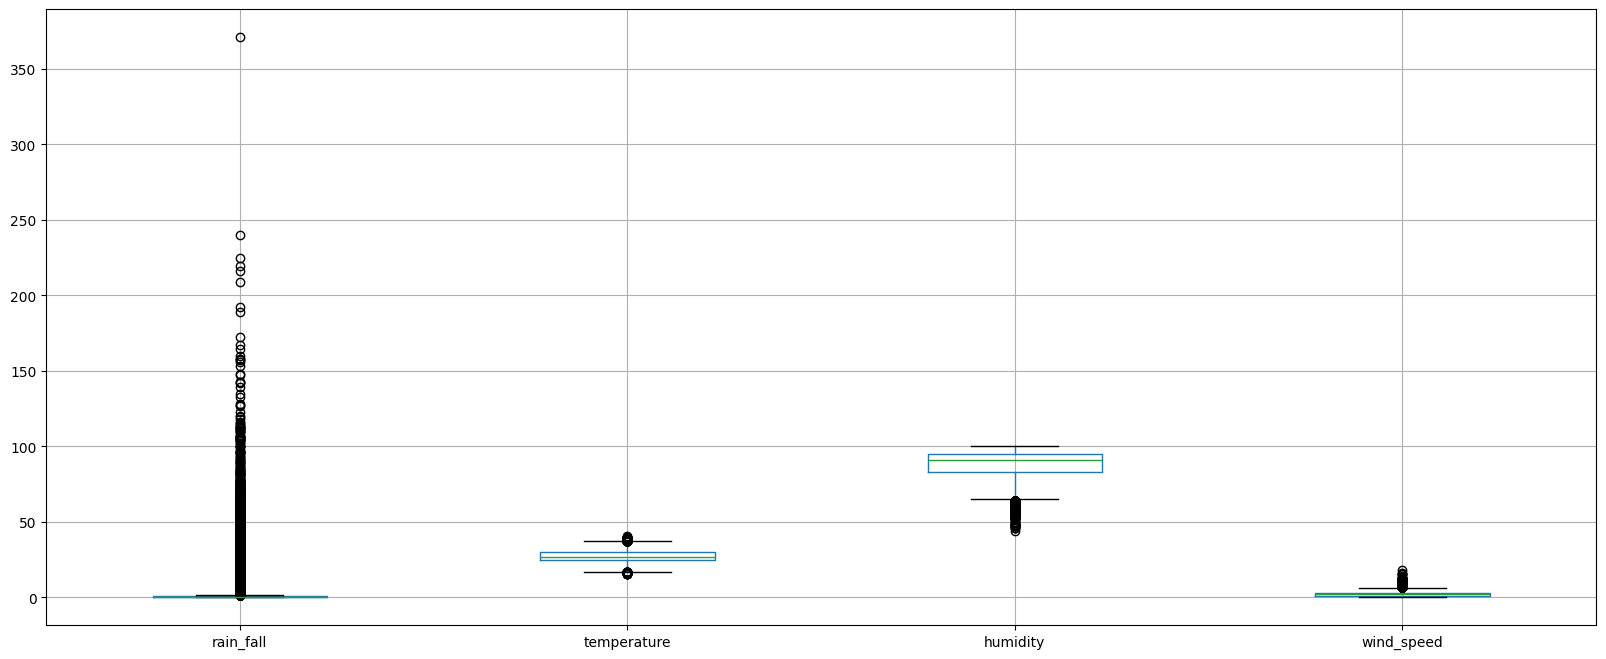

In [40]:
# Check for presence of outliers
plt.figure(figsize=(20,8))
df.boxplot()
plt.show()

Variable name : rain_fall


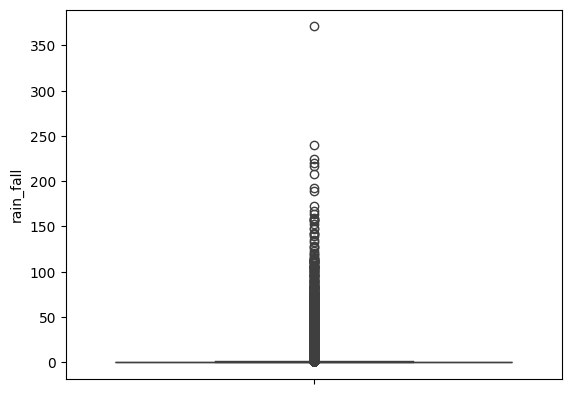

Variable name : temperature


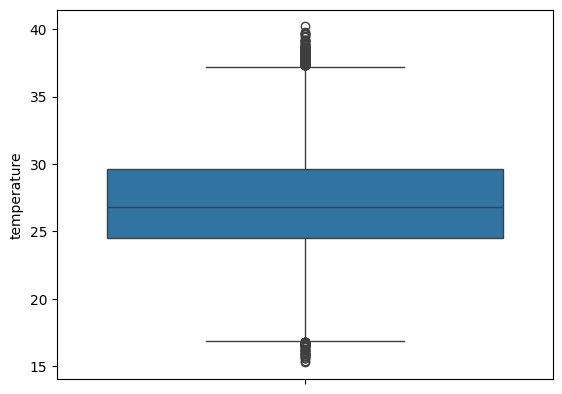

Variable name : humidity


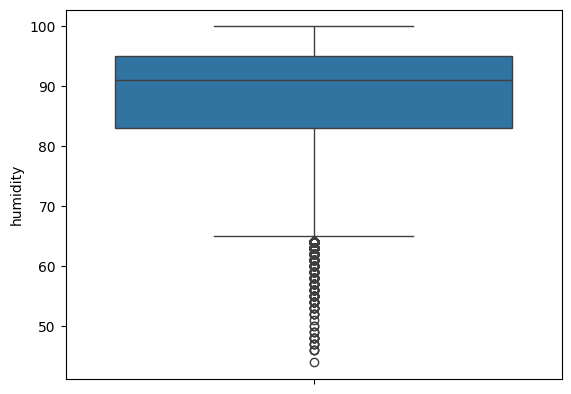

Variable name : wind_speed


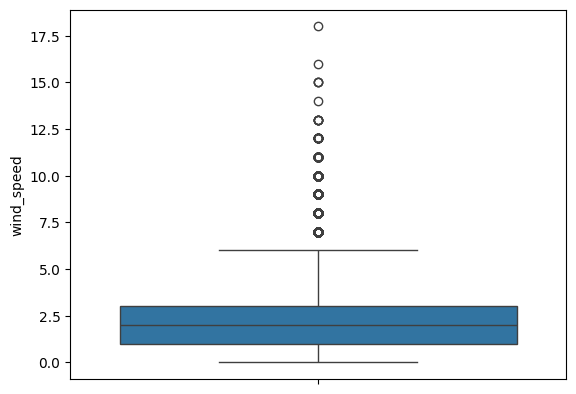

In [41]:
# Check for outliers using box plot for all numerical variable
for col in num_cols:
    print('Variable name :', col)
    sns.boxplot(df[col])
    plt.show()

In [45]:
# Check for presence of duplicate rows and drop it
df.drop_duplicates(inplace=True)

In [ ]:
from sklearn import preprocessing